# 04 — Modelagem Avançada (RF / GB / Threshold / TSCV)

- Usei validação temporal (TimeSeriesSplit)
- Fiz tuning de hiperparâmetros (RandomizedSearchCV)
- Ajustei o **threshold** via CV
- Mostrei matrizes de confusão e importâncias de features
- Salvei resultados em `reports/` e modelo final em `models/`

In [12]:
%matplotlib inline
import pandas as pd, numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context="notebook")

from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
import joblib

In [ ]:
# Carregamento dos dados e preparação de X/y
root = Path('.').resolve()
in_path = root / 'data' / 'processed' / 'ibov_features.parquet'
reports_dir = root / 'reports'
models_dir = root / 'models'
reports_dir.mkdir(parents=True, exist_ok=True)
models_dir.mkdir(parents=True, exist_ok=True)

df = pd.read_parquet(in_path)
y = df['target_next_day_up']
X = df.drop(columns=['target_next_day_up']).select_dtypes(include=['number']).copy()
print('Shape X, y:', X.shape, y.shape)
print('Última data:', df.index.max().date())

Shape X, y: (3870, 24) (3870,)
Última data: 2025-09-12


In [ ]:
# Split temporal: últimos 30 pregões = teste
TEST_SIZE = 30
X_train, X_test = X.iloc[:-TEST_SIZE], X.iloc[-TEST_SIZE:]
y_train, y_test = y.iloc[:-TEST_SIZE], y.iloc[-TEST_SIZE:]
print('Split treino/teste:', X_train.shape, X_test.shape)

Split treino/teste: (3840, 24) (30, 24)


In [15]:
# Funções auxiliares
def tune_threshold_cv(estimator, X, y, cv, grid=None):
    if grid is None:
        grid = np.linspace(0.30, 0.70, 81)
    proba_oof = np.zeros(len(y))
    for train_idx, val_idx in cv.split(X):
        X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
        y_train_cv = y.iloc[train_idx]
        est = clone(estimator)
        est.fit(X_train_cv, y_train_cv)
        if hasattr(est, 'predict_proba'):
            proba_fold = est.predict_proba(X_val_cv)[:, 1]
        else:
            scores = est.decision_function(X_val_cv)
            proba_fold = (scores - scores.min()) / (scores.max() - scores.min() + 1e-9)
        proba_oof[val_idx] = proba_fold
    best_thr, best_acc = 0.5, -1
    for t in grid:
        acc = accuracy_score(y, (proba_oof >= t).astype(int))
        if acc > best_acc:
            best_acc, best_thr = acc, t
    return best_thr, best_acc

def evaluate_and_plot(model, X_test, y_test, threshold, title, save_path=None):
    proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_test)
    if proba.ndim == 1 and (proba.min() < 0 or proba.max() > 1):
        proba = (proba - proba.min()) / (proba.max() - proba.min() + 1e-9)
    y_pred = (proba >= threshold).astype(int)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n{title} — Acurácia teste (thr={threshold:.3f}): {acc:.2%}")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusão — {title}')
    plt.xlabel('Previsto'); plt.ylabel('Real')
    if save_path is not None:
        plt.tight_layout(); plt.savefig(save_path, dpi=120)
    plt.show()
    return acc, cm

## Random Forest — tuning + avaliação

Fitting 5 folds for each of 25 candidates, totalling 125 fits
RF — melhor score CV: 0.51125
RF — melhores params: {'n_estimators': 900, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.9, 'max_depth': None}
Threshold ótimo RF (OOF): 0.380 | Acurácia OOF: 51.72%

Random Forest (thr=0.5) — Acurácia teste (thr=0.500): 63.33%
              precision    recall  f1-score   support

           0       0.58      1.00      0.73        15
           1       1.00      0.27      0.42        15

    accuracy                           0.63        30
   macro avg       0.79      0.63      0.58        30
weighted avg       0.79      0.63      0.58        30



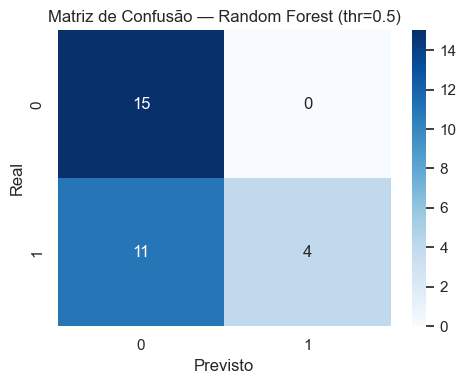


Random Forest (thr otimizado) — Acurácia teste (thr=0.380): 46.67%
              precision    recall  f1-score   support

           0       0.45      0.33      0.38        15
           1       0.47      0.60      0.53        15

    accuracy                           0.47        30
   macro avg       0.46      0.47      0.46        30
weighted avg       0.46      0.47      0.46        30



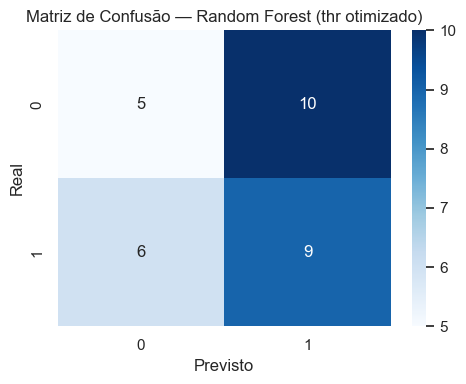

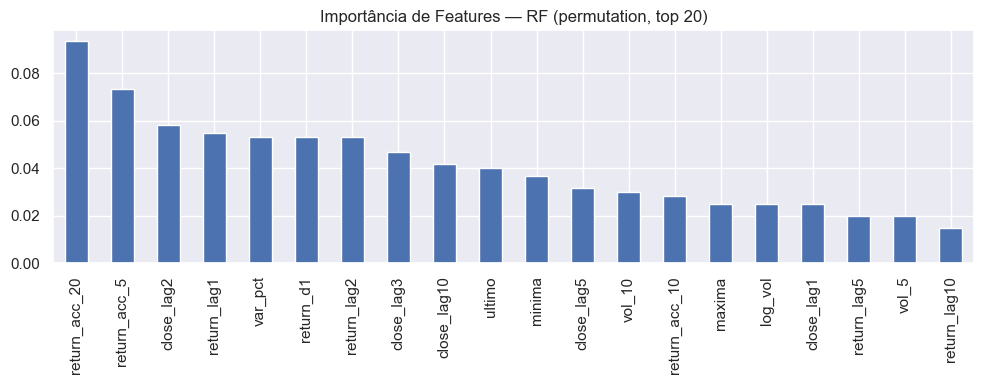

In [16]:
tscv = TimeSeriesSplit(n_splits=5)
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_params = {
    'n_estimators': [300, 600, 900],
    'max_depth': [5, 7, 9, 12, None],
    'min_samples_leaf': [1, 2, 5, 10],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2', 0.6, 0.9]
}
rf_search = RandomizedSearchCV(rf, rf_params, n_iter=25, cv=tscv, scoring='accuracy', random_state=42, n_jobs=-1, verbose=1)
rf_search.fit(X_train, y_train)
print('RF — melhor score CV:', rf_search.best_score_)
print('RF — melhores params:', rf_search.best_params_)
rf_best = rf_search.best_estimator_

thr_rf, acc_oof_rf = tune_threshold_cv(rf_best, X_train, y_train, tscv)
print(f'Threshold ótimo RF (OOF): {thr_rf:.3f} | Acurácia OOF: {acc_oof_rf:.2%}')

acc_rf_05, _  = evaluate_and_plot(rf_best, X_test, y_test, 0.5, 'Random Forest (thr=0.5)', reports_dir / 'confusion_rf_thr05.png')
acc_rf_opt, _ = evaluate_and_plot(rf_best, X_test, y_test, thr_rf, 'Random Forest (thr otimizado)', reports_dir / 'confusion_rf_thropt.png')

imp_rf = permutation_importance(rf_best, X_test, y_test, n_repeats=20, random_state=42)
imp_rf_series = pd.Series(imp_rf.importances_mean, index=X.columns).sort_values(ascending=False)[:20]
plt.figure(figsize=(10,4))
imp_rf_series.plot(kind='bar')
plt.title('Importância de Features — RF (permutation, top 20)')
plt.tight_layout(); plt.savefig(reports_dir / 'features_rf.png', dpi=120); plt.show()

## Gradient Boosting / HistGradientBoosting — tuning + avaliação

Fitting 5 folds for each of 25 candidates, totalling 125 fits
HistGradientBoosting — melhor score CV: 0.521875
HistGradientBoosting — melhores params: {'min_samples_leaf': 50, 'max_leaf_nodes': 63, 'max_depth': 5, 'learning_rate': 0.1, 'l2_regularization': 0.0}
Threshold ótimo HistGradientBoosting (OOF): 0.480 | Acurácia OOF: 51.85%

HistGradientBoosting (thr=0.5) — Acurácia teste (thr=0.500): 60.00%
              precision    recall  f1-score   support

           0       0.56      1.00      0.71        15
           1       1.00      0.20      0.33        15

    accuracy                           0.60        30
   macro avg       0.78      0.60      0.52        30
weighted avg       0.78      0.60      0.52        30



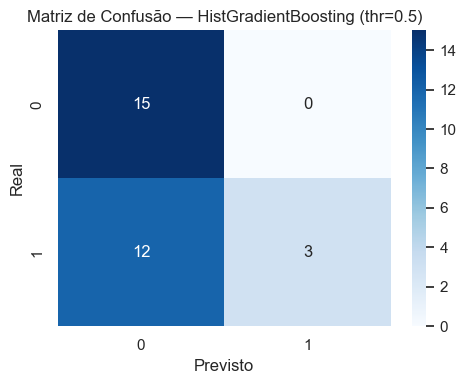


HistGradientBoosting (thr otimizado) — Acurácia teste (thr=0.480): 60.00%
              precision    recall  f1-score   support

           0       0.57      0.87      0.68        15
           1       0.71      0.33      0.45        15

    accuracy                           0.60        30
   macro avg       0.64      0.60      0.57        30
weighted avg       0.64      0.60      0.57        30



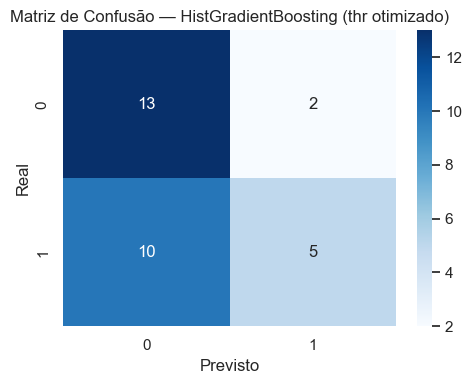

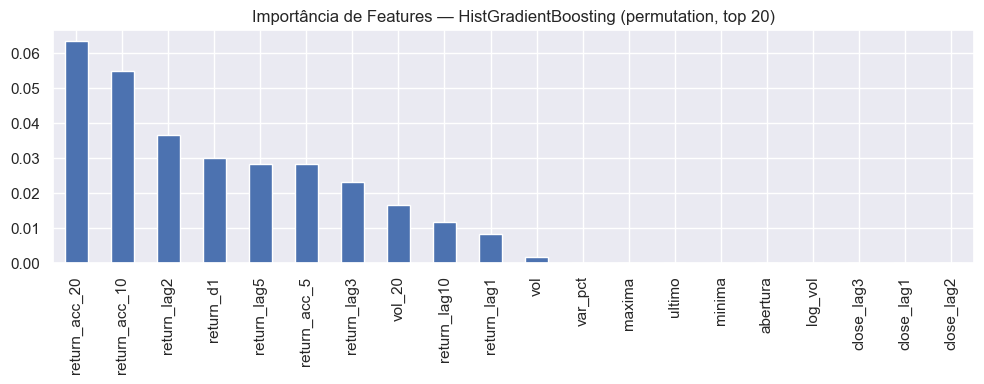

In [17]:
try:
    estimator = HistGradientBoostingClassifier(random_state=42)
    param_grid = {
        'max_depth': [3, 5, 7, None],
        'learning_rate': [0.03, 0.06, 0.10, 0.15],
        'max_leaf_nodes': [15, 31, 63],
        'min_samples_leaf': [10, 20, 50, 100],
        'l2_regularization': [0.0, 0.1, 1.0]
    }
    label = 'HistGradientBoosting'
except Exception:
    estimator = GradientBoostingClassifier(random_state=42)
    param_grid = {
        'n_estimators': [300, 600, 900],
        'learning_rate': [0.03, 0.06, 0.10, 0.15],
        'max_depth': [2, 3, 4],
        'min_samples_leaf': [1, 2, 5, 10]
    }
    label = 'GradientBoosting'

gb_search = RandomizedSearchCV(estimator, param_grid, n_iter=25, cv=tscv, scoring='accuracy', random_state=42, n_jobs=-1, verbose=1)
gb_search.fit(X_train, y_train)
print(f'{label} — melhor score CV:', gb_search.best_score_)
print(f'{label} — melhores params:', gb_search.best_params_)
gb_best = gb_search.best_estimator_

thr_gb, acc_oof_gb = tune_threshold_cv(gb_best, X_train, y_train, tscv)
print(f'Threshold ótimo {label} (OOF): {thr_gb:.3f} | Acurácia OOF: {acc_oof_gb:.2%}')

acc_gb_05, _  = evaluate_and_plot(gb_best, X_test, y_test, 0.5, f'{label} (thr=0.5)', reports_dir / 'confusion_gb_thr05.png')
acc_gb_opt, _ = evaluate_and_plot(gb_best, X_test, y_test, thr_gb, f'{label} (thr otimizado)', reports_dir / 'confusion_gb_thropt.png')

imp_gb = permutation_importance(gb_best, X_test, y_test, n_repeats=20, random_state=42)
imp_gb_series = pd.Series(imp_gb.importances_mean, index=X.columns).sort_values(ascending=False)[:20]
plt.figure(figsize=(10,4))
imp_gb_series.plot(kind='bar')
plt.title(f'Importância de Features — {label} (permutation, top 20)')
plt.tight_layout(); plt.savefig(reports_dir / 'features_gb.png', dpi=120); plt.show()

## Comparativo final + salvando artefatos

In [18]:
results = [
    {'modelo':'RF thr=0.5', 'acc': acc_rf_05},
    {'modelo':'RF thr_opt', 'acc': acc_rf_opt, 'thr': float(thr_rf)},
    {'modelo':f'{label} thr=0.5', 'acc': acc_gb_05},
    {'modelo':f'{label} thr_opt', 'acc': acc_gb_opt, 'thr': float(thr_gb)}
]
res_df = pd.DataFrame(results).sort_values('acc', ascending=False)
print(res_df)

                         modelo       acc   thr
0                    RF thr=0.5  0.633333   NaN
2  HistGradientBoosting thr=0.5  0.600000   NaN
3  HistGradientBoosting thr_opt  0.600000  0.48
1                    RF thr_opt  0.466667  0.38


In [19]:
# Seleciona melhor e salva
best = res_df.iloc[0]
if 'RF' in best['modelo']:
    best_model, best_thr = rf_best, (thr_rf if 'thr_opt' in best['modelo'] else 0.5)
else:
    best_model, best_thr = gb_best, (thr_gb if 'thr_opt' in best['modelo'] else 0.5)
joblib.dump({'model': best_model, 'threshold': float(best_thr), 'features': X.columns.tolist()}, models_dir / 'best_model.pkl')

proba_test = best_model.predict_proba(X_test)[:,1] if hasattr(best_model,'predict_proba') else best_model.decision_function(X_test)
if proba_test.min() < 0 or proba_test.max() > 1:
    proba_test = (proba_test - proba_test.min())/(proba_test.max()-proba_test.min()+1e-9)
pred_test = (proba_test >= best_thr).astype(int)
rep = pd.DataFrame({'date': X_test.index, 'y_true': y_test.values, 'y_proba': proba_test, 'y_pred': pred_test}).set_index('date')
rep.to_csv(reports_dir / 'test_predictions.csv')
print('\nArtefatos salvos:')
print(' - reports/confusion_*.png / features_*.png')
print(' - reports/test_predictions.csv')
print(' - models/best_model.pkl')


Artefatos salvos:
 - reports/confusion_*.png / features_*.png
 - reports/test_predictions.csv
 - models/best_model.pkl
